# FX Volatility Surface Analysis

Historical analysis of FX option volatility surfaces via SABR model calibration.

| Section | Description |
|---------|-------------|
| 0 | Setup & Configuration |
| 1 | Historical FX Options Data (Databento) |
| 2 | FX Spot Data (IB Gateway) |
| 3 | SABR Calibration |
| 4 | ATM Vol (Alpha) Evolution |
| 5 | Skew (Rho) Evolution |
| 6 | Vol-of-Vol (Nu) Evolution |
| 7 | Term Structure Heatmaps |
| 8 | Spot vs SABR Overlay |

**Data sources:**
- FX option prices: Databento GLBX.MDP3 (CME futures options, 3 years)
- FX spot rates: IB Gateway MIDPOINT (interbank, 3 years)
- Implied vols: Computed via Black-76 from settlement prices

---
## Section 0: Setup

In [5]:
%load_ext autoreload
%autoreload 2

import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.figsize': (14, 6), 'font.size': 11})

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / 'src'))
sys.path.insert(0, str(PROJECT_ROOT / 'notebooks'))

DATA_DIR = Path.home() / 'trade_data' / 'ETFTrader'
FX_OPTIONS_DB_DIR = DATA_DIR / 'fx_options_db'
FX_SPOT_DIR = DATA_DIR / 'fx_spot'
FX_SABR_DIR = DATA_DIR / 'fx_sabr'

# Date range for analysis
START_DATE = '2023-02-20'
END_DATE = '2026-02-20'

# Currencies to analyse (CHF excluded — insufficient Databento data)
CURRENCIES = ['EUR', 'GBP', 'AUD', 'CAD', 'JPY']

# Tenor buckets of interest
TENORS = ['1M', '3M', '6M', '1Y']

print(f'Data dir:   {DATA_DIR}')
print(f'Date range: {START_DATE} to {END_DATE}')
print(f'Currencies: {CURRENCIES}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data dir:   /home/stuar/trade_data/ETFTrader
Date range: 2023-02-20 to 2026-02-20
Currencies: ['EUR', 'GBP', 'AUD', 'CAD', 'JPY']


---
## Section 1: Historical FX Options Data (Databento)

Fetch 3 years of CME FX futures option data from Databento.
Settlement prices are converted to implied vols via Black-76.

Set `RUN_COLLECTION = True` for initial fetch (~$13, takes ~30 min).
Subsequent runs load from cache.

In [6]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s', datefmt='%H:%M:%S')

RUN_COLLECTION = False  # Set True for initial Databento fetch

if RUN_COLLECTION:
    from data_collection.databento_fx_collector import DatabentoFXCollector
    collector = DatabentoFXCollector()
    surface = collector.fetch_history(
        currencies=CURRENCIES,
        start=START_DATE,
        end=END_DATE,
    )
else:
    # Load from cache
    dfs = []
    for ccy in CURRENCIES:
        path = FX_OPTIONS_DB_DIR / f'{ccy}_surface.parquet'
        if path.exists():
            df = pd.read_parquet(path)
            dfs.append(df)
            print(f'  {ccy}: {len(df)} rows, {df["timestamp"].nunique()} dates')
        else:
            print(f'  {ccy}: no cached data')
    surface = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

if not surface.empty:
    surface['timestamp'] = pd.to_datetime(surface['timestamp'])
    print(f'\nTotal surface: {len(surface)} rows')
    print(f'  Currencies: {sorted(surface["currency"].unique())}')
    print(f'  Date range: {surface["timestamp"].min().date()} to {surface["timestamp"].max().date()}')
    print(f'  Valid IVs:  {surface["impliedVol"].notna().sum()} / {len(surface)}')
else:
    print('No surface data! Set RUN_COLLECTION = True.')

  EUR: 86957 rows, 887 dates
  GBP: 35876 rows, 822 dates
  AUD: 37628 rows, 839 dates
  CAD: 25741 rows, 817 dates
  JPY: 53053 rows, 862 dates

Total surface: 239255 rows
  Currencies: ['AUD', 'CAD', 'EUR', 'GBP', 'JPY']
  Date range: 2023-02-20 to 2026-02-19
  Valid IVs:  234253 / 239255


---
## Section 2: FX Spot Data (IB Gateway)

Collect 3 years of FX spot midpoint rates from IB.
Set `RUN_SPOT_COLLECTION = True` with IB Gateway running for initial fetch.

In [7]:
RUN_SPOT_COLLECTION = True  # Set True with IB Gateway running

if RUN_SPOT_COLLECTION:
    import nest_asyncio
    nest_asyncio.apply()
    from ib_insync import IB
    from data_collection.fx_spot_collector import FXSpotCollector

    ib = IB()
    ib.connect('127.0.0.1', 4001, clientId=25, readonly=True, timeout=10)
    print(f'Connected: {ib.managedAccounts()[0]}')

    spot_collector = FXSpotCollector(ib, cache_dir=str(FX_SPOT_DIR))
    spots, results = spot_collector.collect_all_extended(years=3)
    ib.disconnect()
else:
    print('Loading spot data from cache...')

# Build spot matrix from cache (works whether we just collected or not)
from data_collection.fx_spot_collector import FXSpotCollector, FX_PAIRS

spot_dfs = []
for ccy, pair in FX_PAIRS.items():
    path = FX_SPOT_DIR / f'{pair}.parquet'
    if path.exists():
        df = pd.read_parquet(path)
        df['date'] = pd.to_datetime(df['date'])
        spot_dfs.append(df[['date', 'currency', 'close']].copy())
        print(f'  {pair}: {len(df)} bars ({df["date"].min().date()} to {df["date"].max().date()})')

if spot_dfs:
    spot_all = pd.concat(spot_dfs, ignore_index=True)
    spot_matrix = spot_all.pivot_table(index='date', columns='currency', values='close').sort_index()
    print(f'\nSpot matrix: {spot_matrix.shape[1]} pairs x {len(spot_matrix)} days')
else:
    spot_matrix = pd.DataFrame()
    print('No spot data cached. Set RUN_SPOT_COLLECTION = True with IB Gateway.')

16:28:52 Connecting to 127.0.0.1:4001 with clientId 25...
16:28:52 Connected


16:28:52 Logged on to server version 176
16:28:52 Warning 2104, reqId -1: Market data farm connection is OK:usfarm
16:28:52 Warning 2107, reqId -1: HMDS data farm connection is inactive but should be available upon demand.ushmds
16:28:52 Warning 2158, reqId -1: Sec-def data farm connection is OK:secdefnj
16:28:52 API connection ready
16:28:52 position: Position(account='U9544585', contract=Stock(conId=245170131, symbol='HDMV', exchange='ARCA', currency='USD', localSymbol='HDMV', tradingClass='HDMV'), position=107.0, avgCost=38.4886916)
16:28:52 position: Position(account='U9544585', contract=Stock(conId=139508763, symbol='FYLD', exchange='BATS', currency='USD', localSymbol='FYLD', tradingClass='FYLD'), position=111.0, avgCost=37.27135135)
16:28:52 position: Position(account='U9544585', contract=Stock(conId=185345348, symbol='ROAM', exchange='ARCA', currency='USD', localSymbol='ROAM', tradingClass='ROAM'), position=128.0, avgCost=32.49296875)
16:28:52 position: Position(account='U954458

Connected: U9544585

FX Spot Extended Collection — 6 pairs, 3 years



16:28:55 Warning 2106, reqId -1: HMDS data farm connection is OK:cashhmds


  EURUSD: request 1/3 — 259 bars back to 2025-02-21
  EURUSD: request 2/3 — 259 bars back to 2024-02-23
  EURUSD: request 3/3 — 258 bars back to 2023-02-24
  EURUSD: 775 bars (2023-02-24 to 2026-02-20)
  GBPUSD: request 1/3 — 259 bars back to 2025-02-21
  GBPUSD: request 2/3 — 259 bars back to 2024-02-23
  GBPUSD: request 3/3 — 258 bars back to 2023-02-24
  GBPUSD: 775 bars (2023-02-24 to 2026-02-20)
  AUDUSD: request 1/3 — 259 bars back to 2025-02-21
  AUDUSD: request 2/3 — 259 bars back to 2024-02-23
  AUDUSD: request 3/3 — 258 bars back to 2023-02-24
  AUDUSD: 775 bars (2023-02-24 to 2026-02-20)
  USDCAD: request 1/3 — 259 bars back to 2025-02-21
  USDCAD: request 2/3 — 259 bars back to 2024-02-23
  USDCAD: request 3/3 — 258 bars back to 2023-02-24
  USDCAD: 775 bars (2023-02-24 to 2026-02-20)
  USDCHF: request 1/3 — 259 bars back to 2025-02-21
  USDCHF: request 2/3 — 259 bars back to 2024-02-23
  USDCHF: request 3/3 — 258 bars back to 2023-02-24
  USDCHF: 775 bars (2023-02-24 to 20

16:29:54 Disconnecting from 127.0.0.1:4001, 2.29 kB sent in 30 messages, 269 kB received in 456 messages, session time 62.3 s.
16:29:54 Disconnecting



Total: 4650 bars across 6 pairs
  EURUSD: 775 bars (2023-02-24 to 2026-02-20)
  GBPUSD: 775 bars (2023-02-24 to 2026-02-20)
  AUDUSD: 775 bars (2023-02-24 to 2026-02-20)
  USDCAD: 775 bars (2023-02-24 to 2026-02-20)
  USDCHF: 775 bars (2023-02-24 to 2026-02-20)
  USDJPY: 775 bars (2023-02-24 to 2026-02-20)

Spot matrix: 6 pairs x 775 days


16:29:54 Disconnected.


---
## Section 3: SABR Calibration

Fit the simplified SABR model (beta=1, lognormal) to each daily surface slice.
Extracts alpha (ATM vol), rho (skew), nu (vol-of-vol) per (date, currency, tenor).

In [8]:
from fx_options.sabr import calibrate_surface, assign_tenor_bucket

# Run SABR calibration
sabr_params = calibrate_surface(surface, min_strikes=5, use_mid_iv=True)

if not sabr_params.empty:
    # Add time-scaled metrics
    sabr_params['T'] = sabr_params['dte'].clip(lower=1) / 365.0
    sabr_params['nu_sqrt_T'] = sabr_params['nu'] * np.sqrt(sabr_params['T'])
    sabr_params['timestamp'] = pd.to_datetime(sabr_params['timestamp'])
    sabr_params['date'] = sabr_params['timestamp'].dt.date

    # Save historical SABR parameters
    FX_SABR_DIR.mkdir(parents=True, exist_ok=True)
    sabr_path = FX_SABR_DIR / 'sabr_params_historical.parquet'
    sabr_params.to_parquet(sabr_path, index=False)

    print(f'SABR calibration: {len(sabr_params)} slices')
    print(f'  Success rate: {sabr_params["calibration_success"].mean()*100:.0f}%')
    print(f'  Median RMSE: {sabr_params["rmse"].median():.6f}')
    print(f'  Date range: {sabr_params["timestamp"].min().date()} to {sabr_params["timestamp"].max().date()}')
    print(f'  Currencies: {sorted(sabr_params["currency"].unique())}')
    print(f'  Saved: {sabr_path}')
else:
    print('No SABR results — check surface data above.')

16:33:45 Calibrated 14020/14020 slices (100% success), median RMSE: 0.003471


SABR calibration: 14020 slices
  Success rate: 100%
  Median RMSE: 0.003471
  Date range: 2023-02-20 to 2026-02-19
  Currencies: ['AUD', 'CAD', 'EUR', 'GBP', 'JPY']
  Saved: /home/stuar/trade_data/ETFTrader/fx_sabr/sabr_params_historical.parquet


---
## Section 4: ATM Vol (Alpha) Evolution

Alpha is the ATM implied volatility in the SABR model.
Shows how overall vol levels have evolved by currency and tenor.

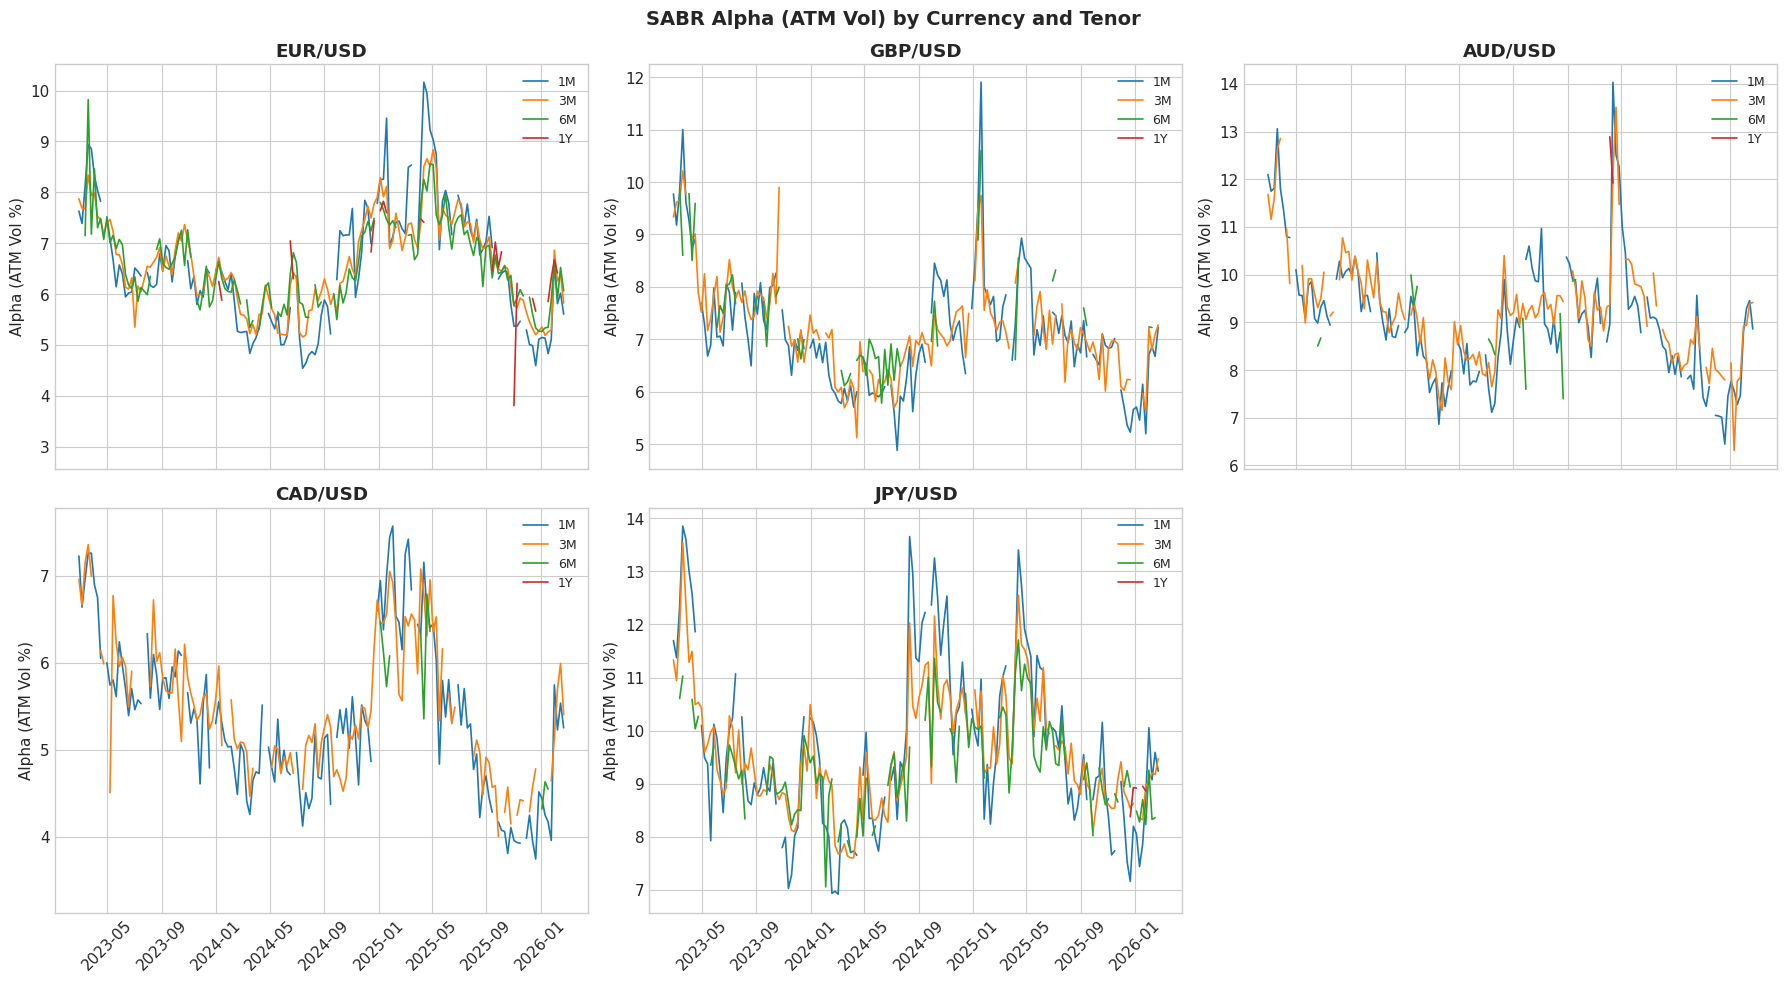

In [9]:
ncols = 3
nrows = (len(CURRENCIES) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows), sharex=True)
axes = axes.flatten()

for idx, ccy in enumerate(CURRENCIES):
    ax = axes[idx]
    ccy_data = sabr_params[sabr_params['currency'] == ccy]

    for tenor in TENORS:
        tenor_data = ccy_data[ccy_data['tenor_bucket'] == tenor].sort_values('timestamp')
        if not tenor_data.empty:
            # Rolling median to smooth day-to-day noise
            ts = tenor_data.set_index('timestamp')['alpha'].resample('W').median()
            ax.plot(ts.index, ts.values * 100, label=tenor, linewidth=1.2)

    ax.set_title(f'{ccy}/USD', fontweight='bold')
    ax.set_ylabel('Alpha (ATM Vol %)')
    ax.legend(fontsize=9)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)

# Hide unused subplots
for idx in range(len(CURRENCIES), len(axes)):
    axes[idx].set_visible(False)

fig.suptitle('SABR Alpha (ATM Vol) by Currency and Tenor', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

---
## Section 5: Skew (Rho) Evolution

Rho captures the correlation between spot and volatility — the skew direction.
Negative rho = downside skew (puts more expensive than calls).

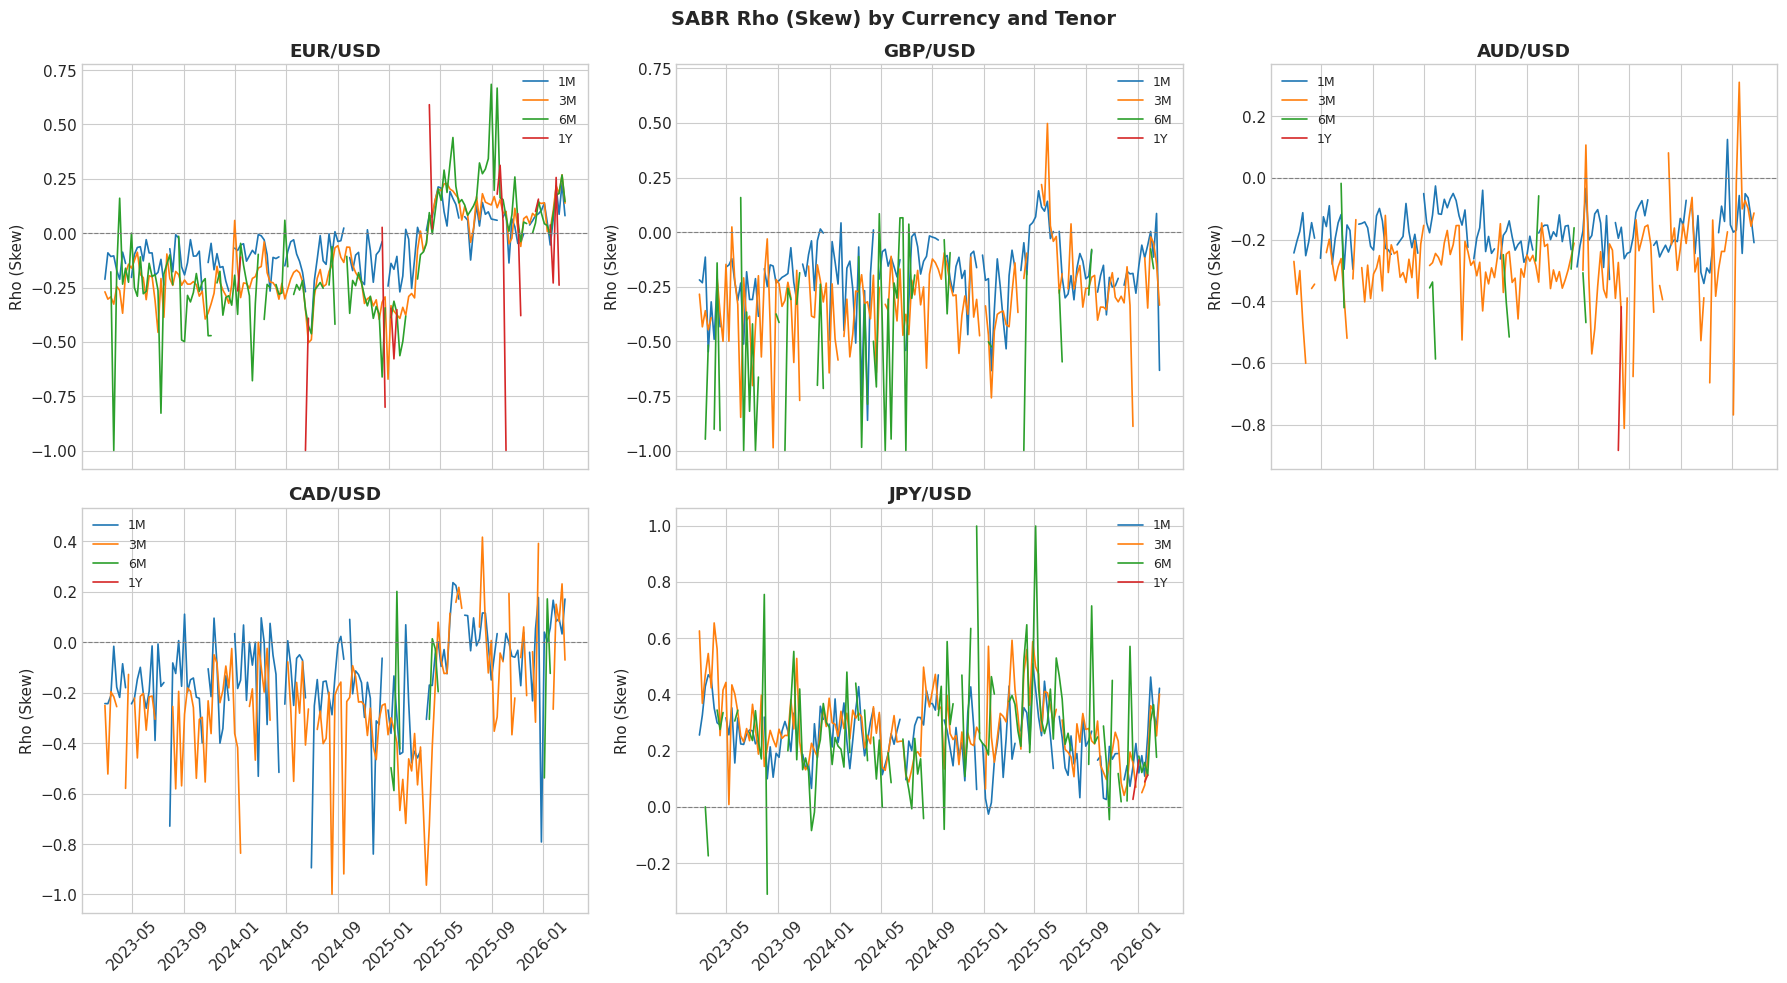

In [10]:
ncols = 3
nrows = (len(CURRENCIES) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows), sharex=True)
axes = axes.flatten()

for idx, ccy in enumerate(CURRENCIES):
    ax = axes[idx]
    ccy_data = sabr_params[sabr_params['currency'] == ccy]

    for tenor in TENORS:
        tenor_data = ccy_data[ccy_data['tenor_bucket'] == tenor].sort_values('timestamp')
        if not tenor_data.empty:
            ts = tenor_data.set_index('timestamp')['rho'].resample('W').median()
            ax.plot(ts.index, ts.values, label=tenor, linewidth=1.2)

    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    ax.set_title(f'{ccy}/USD', fontweight='bold')
    ax.set_ylabel('Rho (Skew)')
    ax.legend(fontsize=9)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)

for idx in range(len(CURRENCIES), len(axes)):
    axes[idx].set_visible(False)

fig.suptitle('SABR Rho (Skew) by Currency and Tenor', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

---
## Section 6: Vol-of-Vol (Nu) Evolution

Nu captures the curvature of the smile.
Nu * sqrt(T) should be approximately constant across tenors if the model is consistent.

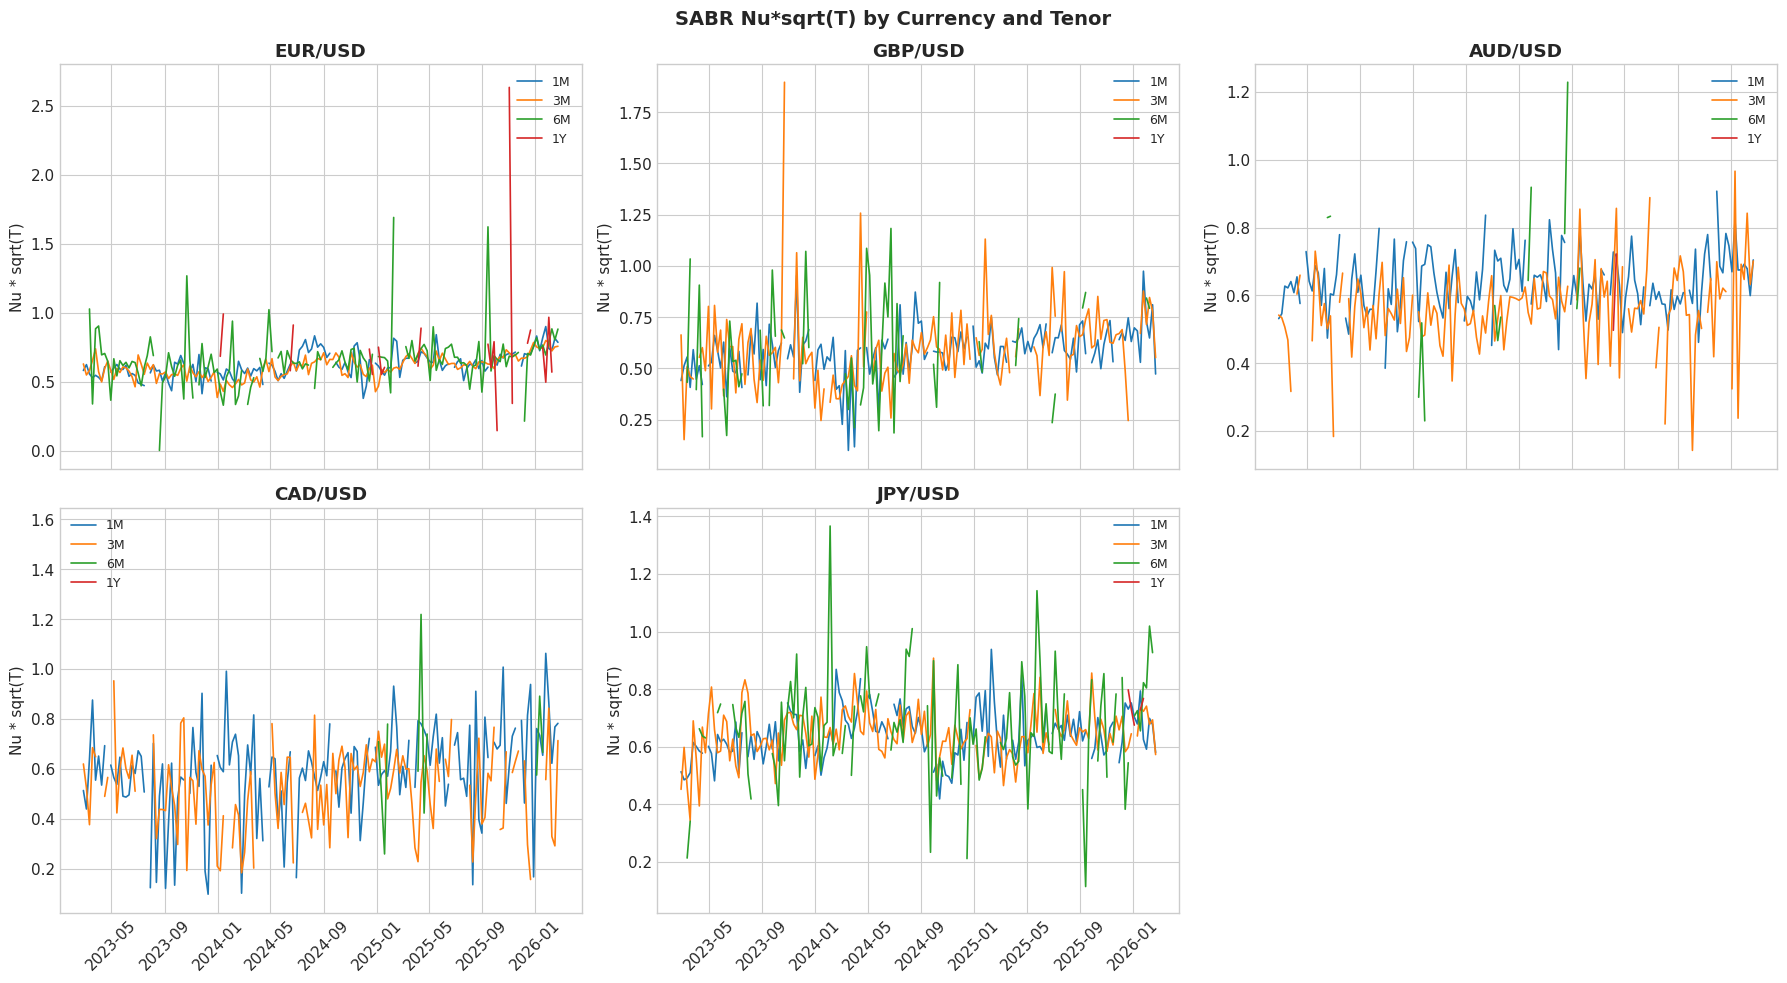

In [11]:
ncols = 3
nrows = (len(CURRENCIES) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows), sharex=True)
axes = axes.flatten()

for idx, ccy in enumerate(CURRENCIES):
    ax = axes[idx]
    ccy_data = sabr_params[sabr_params['currency'] == ccy]

    for tenor in TENORS:
        tenor_data = ccy_data[ccy_data['tenor_bucket'] == tenor].sort_values('timestamp')
        if not tenor_data.empty:
            ts = tenor_data.set_index('timestamp')['nu_sqrt_T'].resample('W').median()
            ax.plot(ts.index, ts.values, label=tenor, linewidth=1.2)

    ax.set_title(f'{ccy}/USD', fontweight='bold')
    ax.set_ylabel('Nu * sqrt(T)')
    ax.legend(fontsize=9)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)

for idx in range(len(CURRENCIES), len(axes)):
    axes[idx].set_visible(False)

fig.suptitle('SABR Nu*sqrt(T) by Currency and Tenor', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

---
## Section 7: Term Structure Heatmaps

Heatmap of SABR parameters across time (x-axis) and tenor (y-axis).

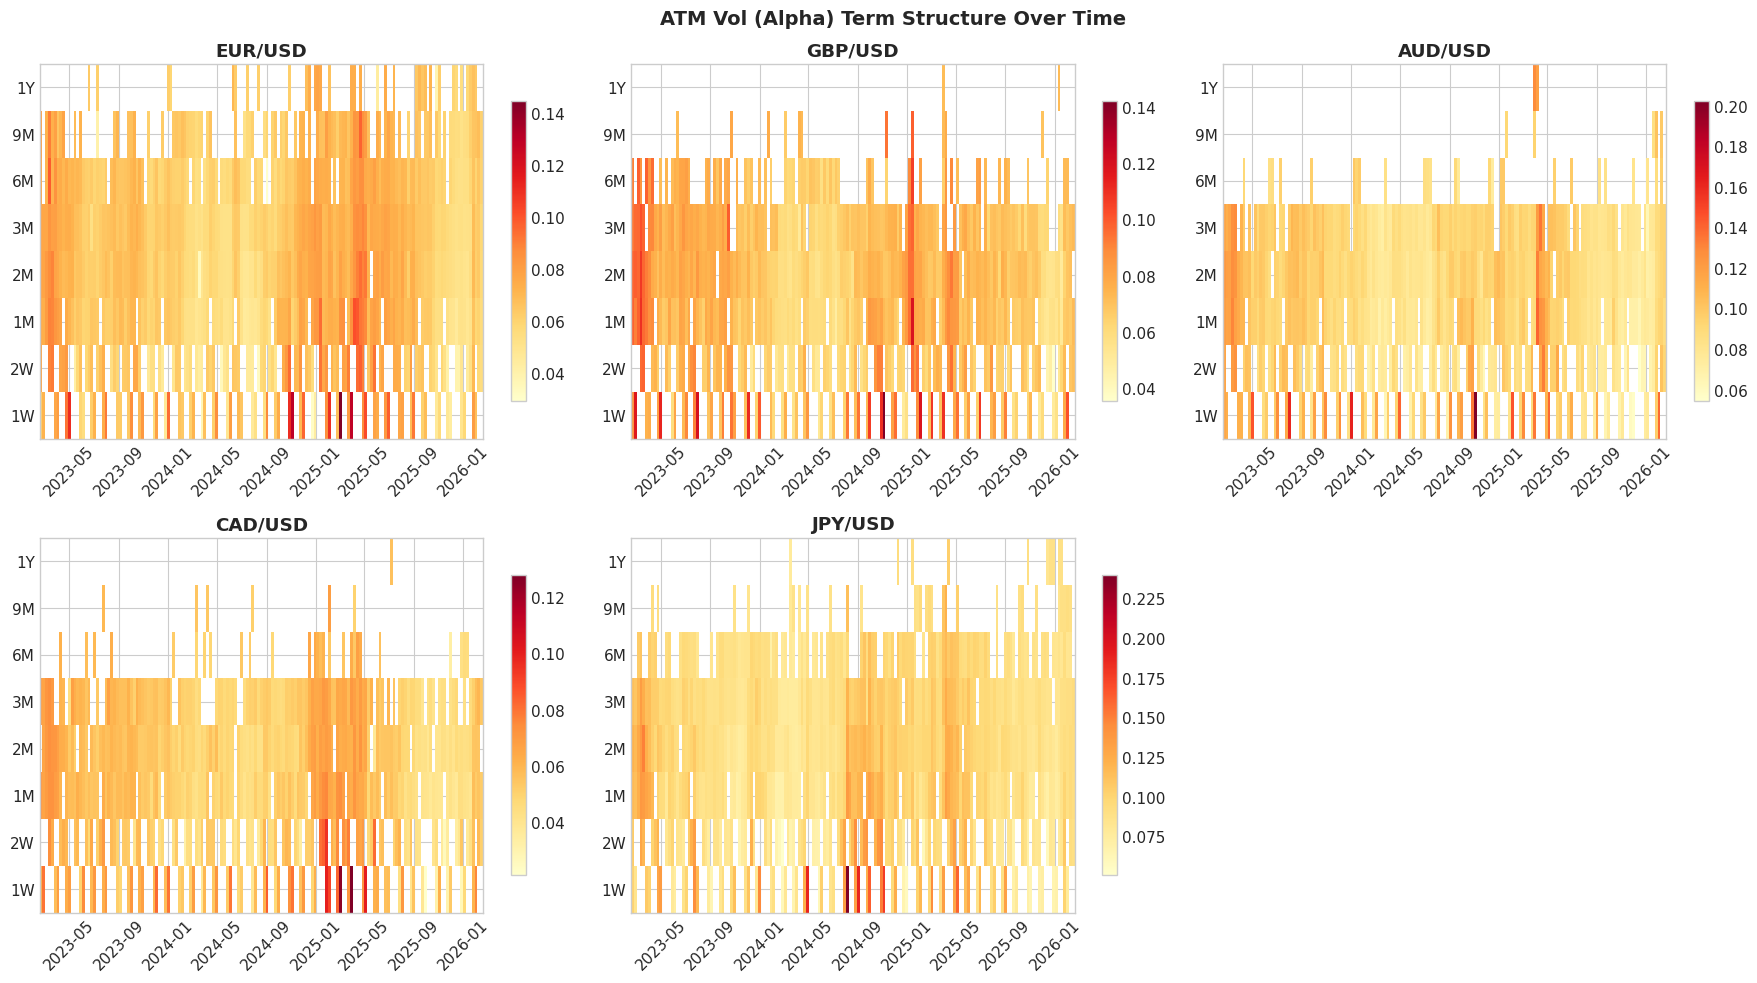

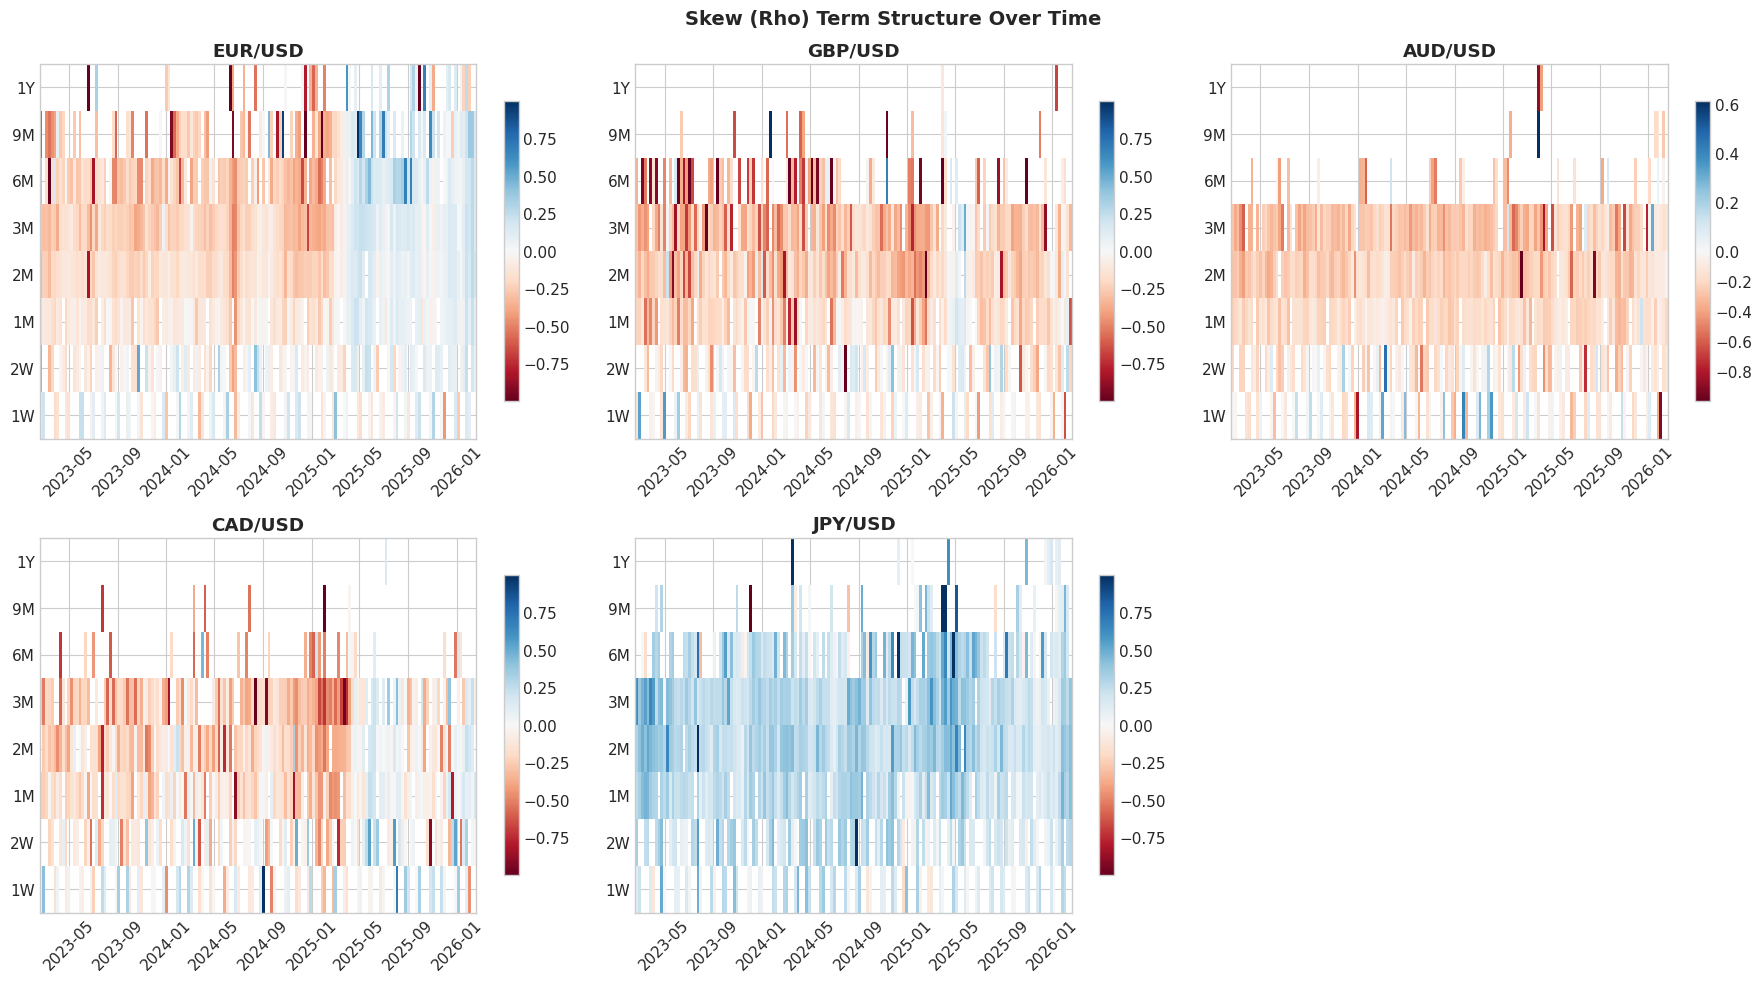

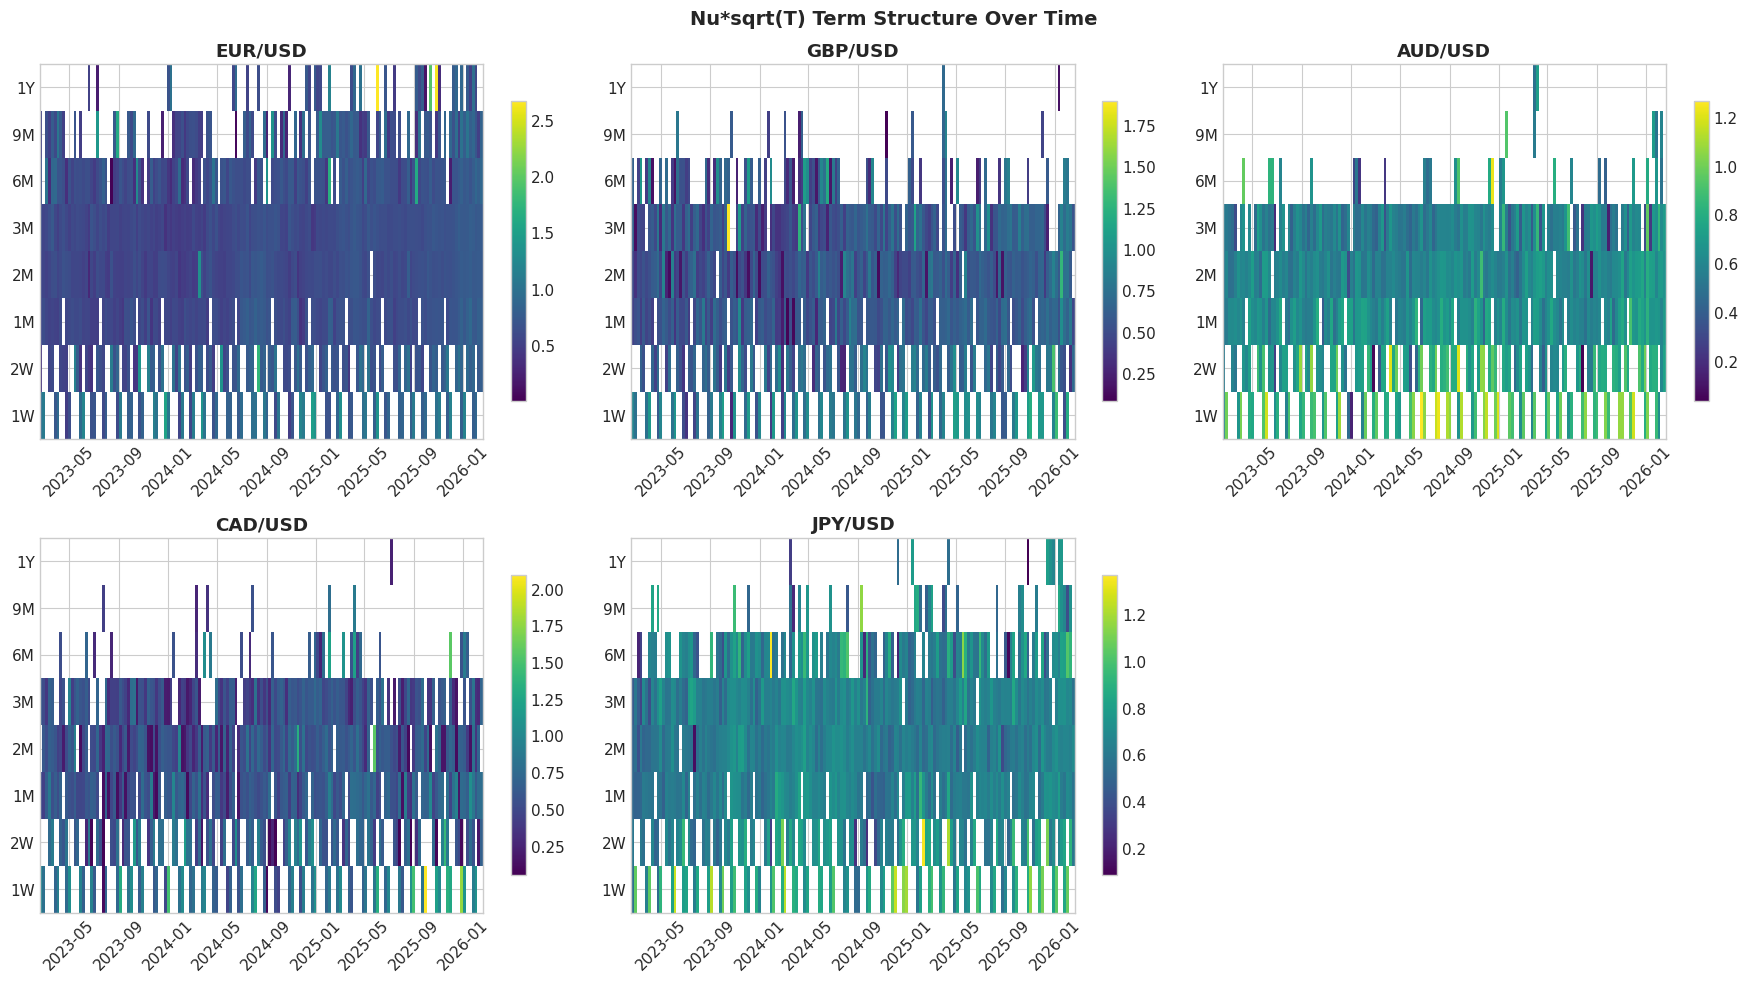

In [12]:
from matplotlib.colors import TwoSlopeNorm

def plot_param_heatmap(param_name, title, cmap='RdYlBu_r', center=None):
    """Plot heatmap of a SABR parameter across currencies, time, and tenor."""
    ncols = 3
    nrows = (len(CURRENCIES) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows))
    axes = axes.flatten()

    for idx, ccy in enumerate(CURRENCIES):
        ax = axes[idx]
        ccy_data = sabr_params[sabr_params['currency'] == ccy].copy()
        ccy_data['week'] = ccy_data['timestamp'].dt.to_period('W').dt.start_time

        # Pivot: weekly median of param by tenor
        pivot = ccy_data.pivot_table(
            index='tenor_bucket', columns='week',
            values=param_name, aggfunc='median'
        )

        # Reorder tenors
        tenor_order = [t for t in ['1W', '2W', '1M', '2M', '3M', '6M', '9M', '1Y'] if t in pivot.index]
        pivot = pivot.reindex(tenor_order)

        if center is not None:
            norm = TwoSlopeNorm(vmin=pivot.min().min(), vcenter=center, vmax=pivot.max().max())
            im = ax.pcolormesh(pivot.columns, range(len(pivot.index)), pivot.values, cmap=cmap, norm=norm)
        else:
            im = ax.pcolormesh(pivot.columns, range(len(pivot.index)), pivot.values, cmap=cmap)

        ax.set_yticks(range(len(pivot.index)))
        ax.set_yticklabels(pivot.index)
        ax.set_title(f'{ccy}/USD', fontweight='bold')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', rotation=45)
        plt.colorbar(im, ax=ax, shrink=0.8)

    for idx in range(len(CURRENCIES), len(axes)):
        axes[idx].set_visible(False)

    fig.suptitle(title, fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()

# Alpha heatmap
plot_param_heatmap('alpha', 'ATM Vol (Alpha) Term Structure Over Time', cmap='YlOrRd')

# Rho heatmap
plot_param_heatmap('rho', 'Skew (Rho) Term Structure Over Time', cmap='RdBu', center=0)

# Nu*sqrt(T) heatmap
plot_param_heatmap('nu_sqrt_T', 'Nu*sqrt(T) Term Structure Over Time', cmap='viridis')

---
## Section 8: Spot vs SABR Overlay

Overlays FX spot returns with SABR parameter changes to identify
relationships between spot movements and vol surface dynamics.

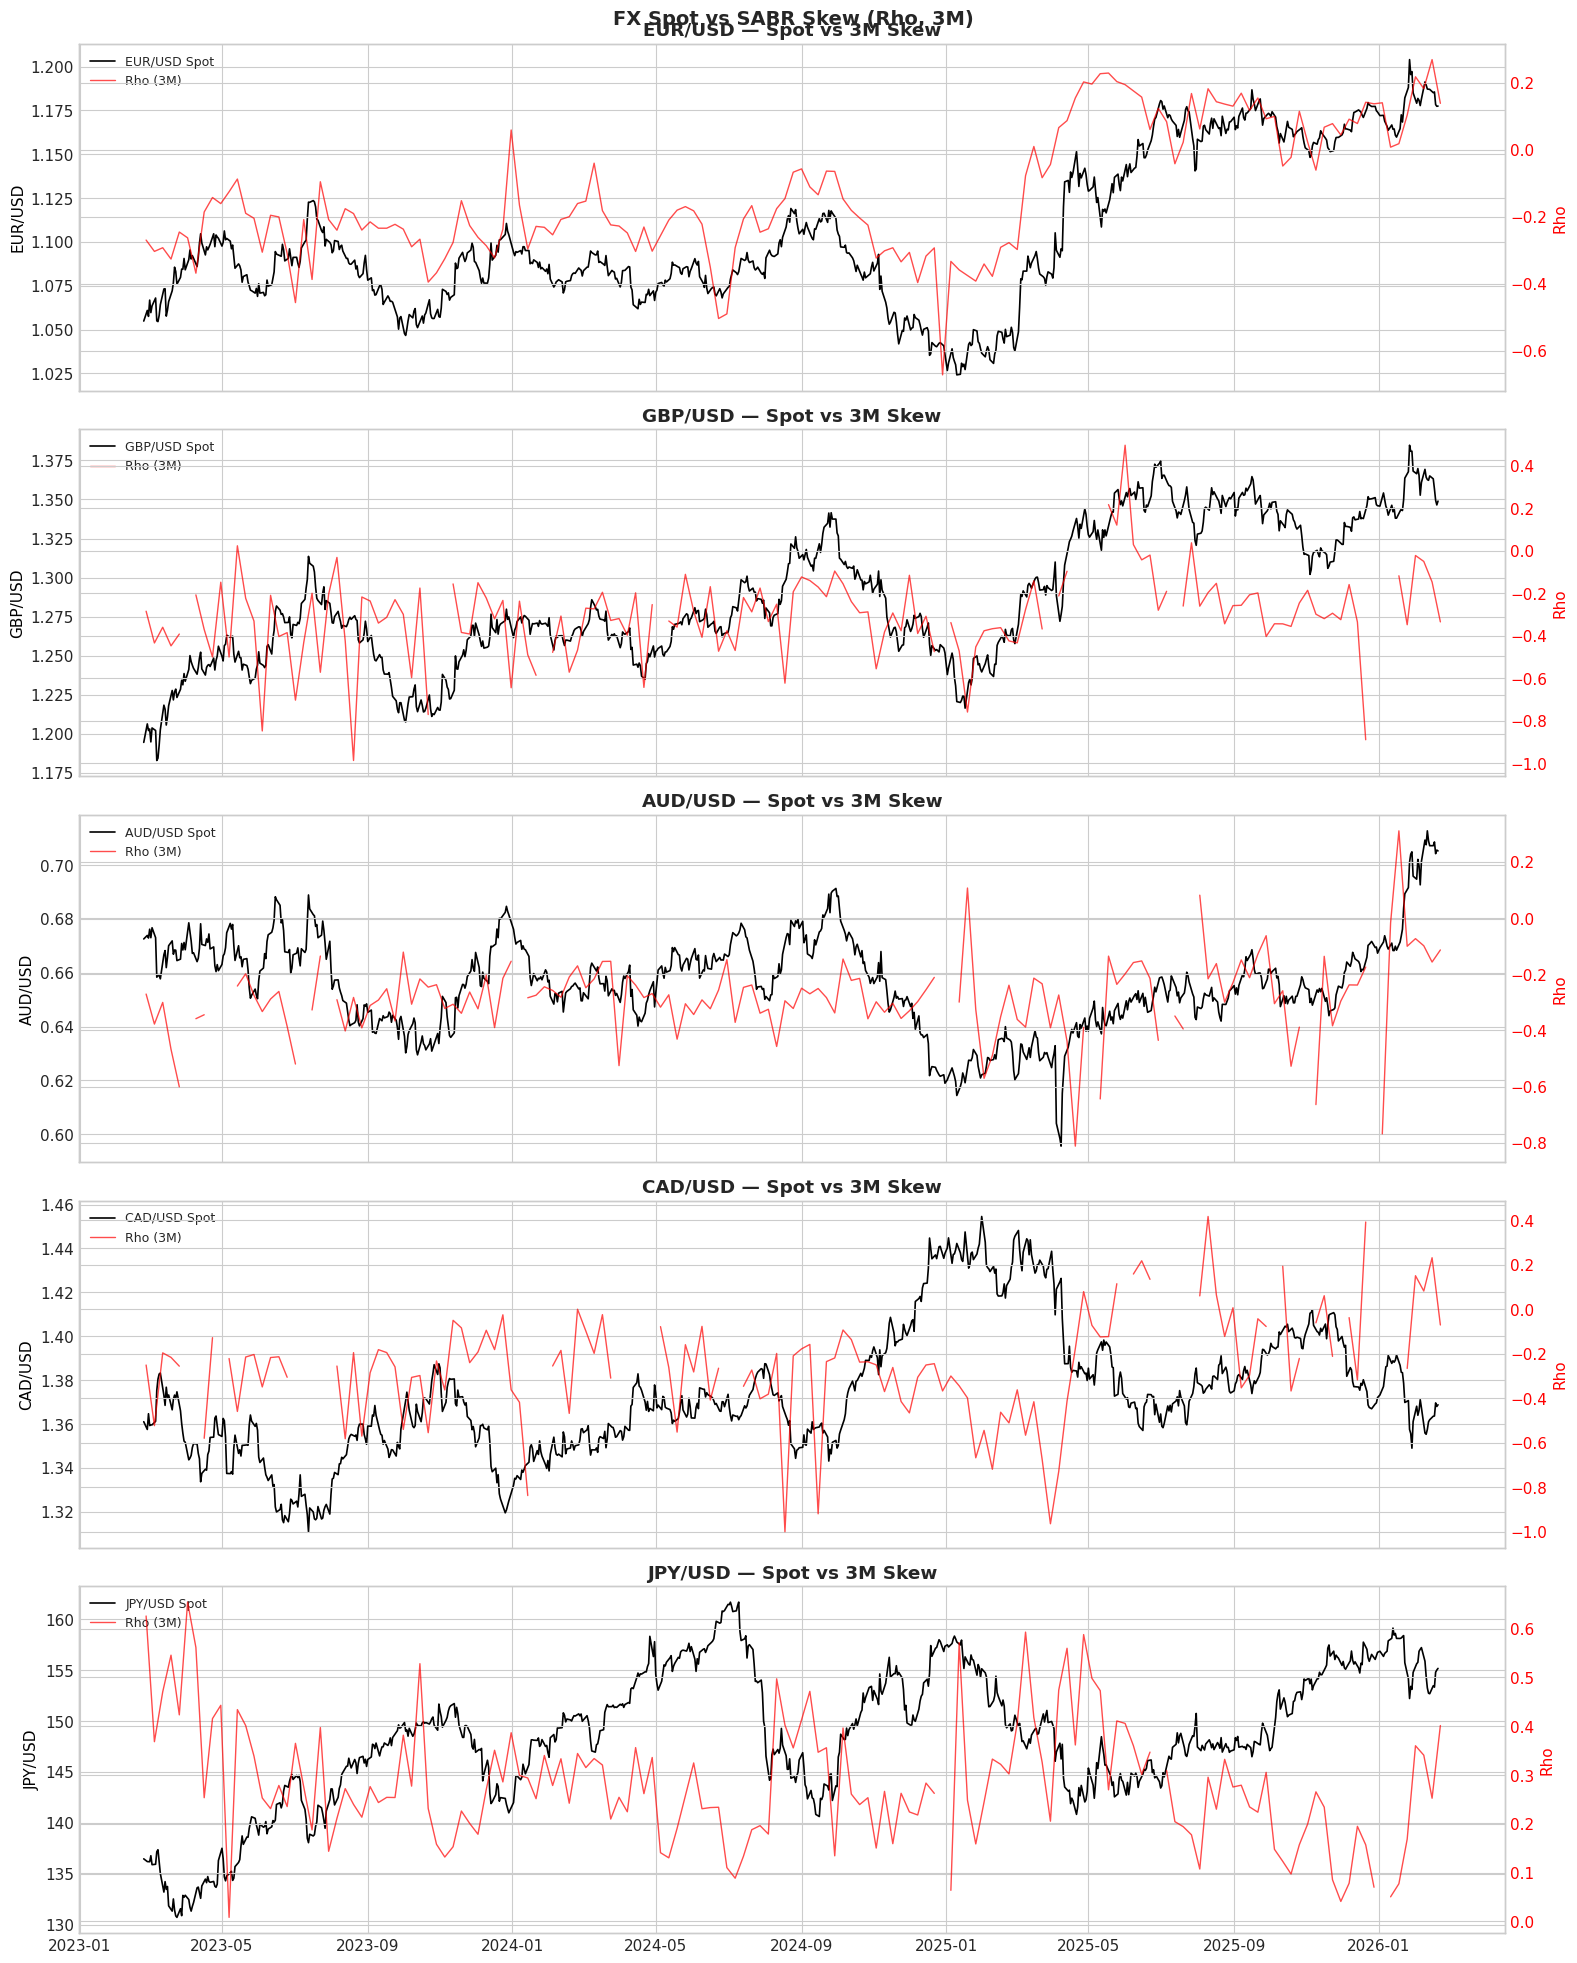

In [13]:
if spot_matrix.empty:
    print('No spot data available. Run Section 2 with IB Gateway to collect.')
else:
    fig, axes = plt.subplots(len(CURRENCIES), 1, figsize=(16, 4 * len(CURRENCIES)), sharex=True)
    if len(CURRENCIES) == 1:
        axes = [axes]

    for idx, ccy in enumerate(CURRENCIES):
        ax = axes[idx]

        # Spot price
        if ccy in spot_matrix.columns:
            spot = spot_matrix[ccy].dropna()
            ax.plot(spot.index, spot.values, color='black', linewidth=1.2, label=f'{ccy}/USD Spot')
            ax.set_ylabel(f'{ccy}/USD', color='black')

        # SABR rho overlay (3M tenor)
        ax2 = ax.twinx()
        ccy_sabr = sabr_params[
            (sabr_params['currency'] == ccy) & (sabr_params['tenor_bucket'] == '3M')
        ].sort_values('timestamp')

        if not ccy_sabr.empty:
            ts = ccy_sabr.set_index('timestamp')['rho'].resample('W').median()
            ax2.plot(ts.index, ts.values, color='red', linewidth=1.0, alpha=0.7, label='Rho (3M)')
            ax2.set_ylabel('Rho', color='red')
            ax2.tick_params(axis='y', labelcolor='red')

        ax.set_title(f'{ccy}/USD — Spot vs 3M Skew', fontweight='bold')
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.suptitle('FX Spot vs SABR Skew (Rho, 3M)', fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()

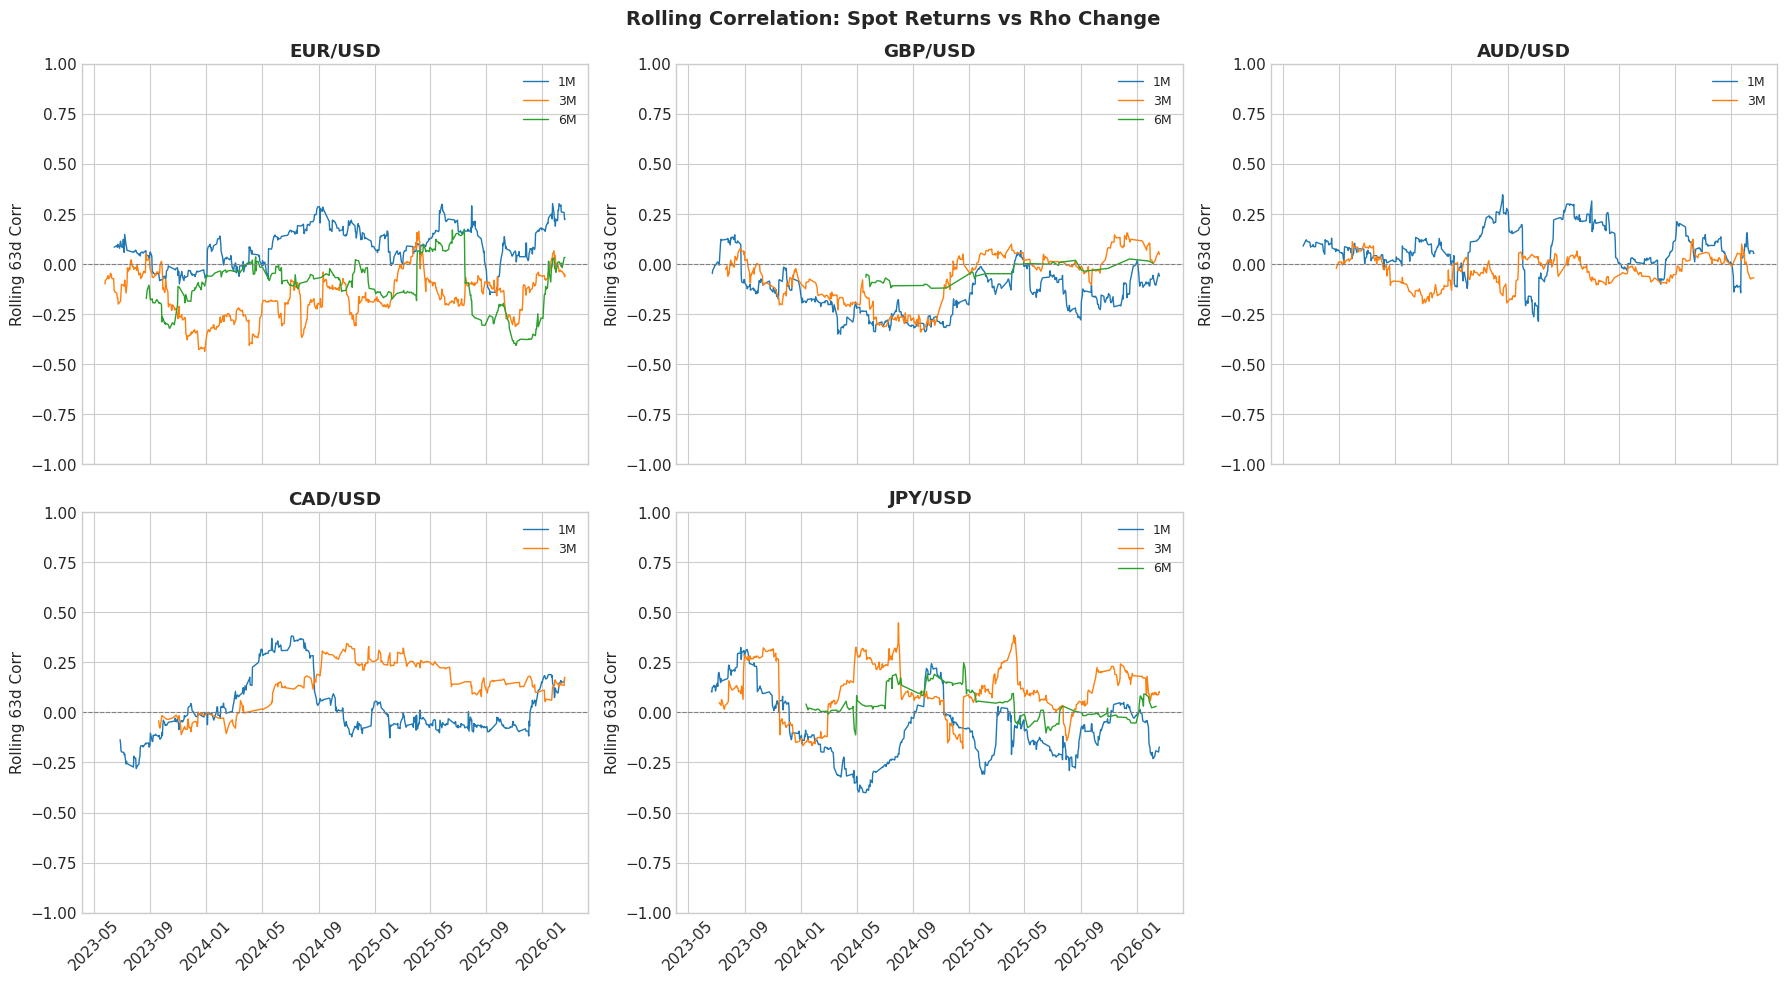

In [14]:
# Rolling correlation between spot returns and rho changes
if not spot_matrix.empty:
    ncols = 3
    nrows = (len(CURRENCIES) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows), sharex=True)
    axes = axes.flatten()

    for idx, ccy in enumerate(CURRENCIES):
        ax = axes[idx]

        if ccy not in spot_matrix.columns:
            ax.set_title(f'{ccy}/USD — no spot data')
            continue

        spot_ret = spot_matrix[ccy].pct_change()

        for tenor in ['1M', '3M', '6M']:
            ccy_sabr = sabr_params[
                (sabr_params['currency'] == ccy) & (sabr_params['tenor_bucket'] == tenor)
            ].sort_values('timestamp')

            if ccy_sabr.empty:
                continue

            # Daily rho change
            rho_ts = ccy_sabr.set_index('timestamp')['rho'].resample('B').last().dropna()
            rho_change = rho_ts.diff()

            # Align
            aligned = pd.DataFrame({'spot_ret': spot_ret, 'rho_change': rho_change}).dropna()
            if len(aligned) > 63:
                corr = aligned['spot_ret'].rolling(63).corr(aligned['rho_change'])
                ax.plot(corr.index, corr.values, label=tenor, linewidth=1.0)

        ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
        ax.set_title(f'{ccy}/USD', fontweight='bold')
        ax.set_ylabel('Rolling 63d Corr')
        ax.set_ylim(-1, 1)
        ax.legend(fontsize=9)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', rotation=45)

    for idx in range(len(CURRENCIES), len(axes)):
        axes[idx].set_visible(False)

    fig.suptitle('Rolling Correlation: Spot Returns vs Rho Change', fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()

---

**Summary:** This notebook provides a comprehensive view of FX volatility surface dynamics.
Key outputs for further analysis:

- `~/trade_data/ETFTrader/fx_sabr/sabr_params_historical.parquet` — Full SABR parameter history
- The SABR parameters (alpha, rho, nu) can be used as features for FX trading signals